In [1]:
from pprint import PrettyPrinter

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax import jit
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
pp = PrettyPrinter(indent=4)
key = jr.PRNGKey(123)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/dasc/hardik/FORESEE/venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
n = 100
noise = 0.3

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

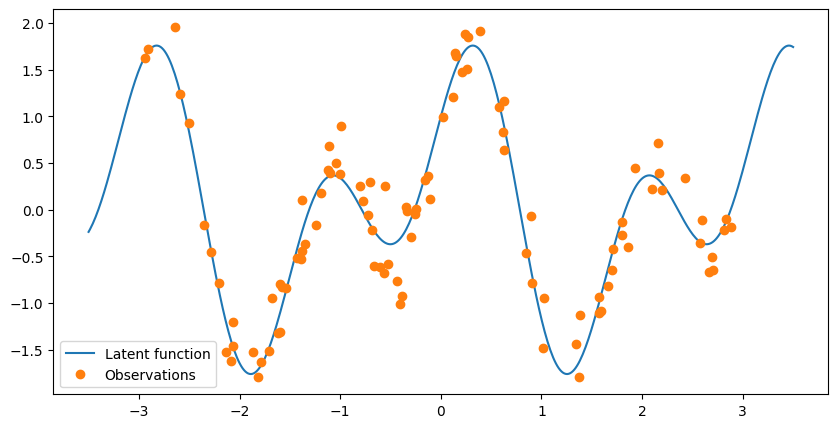

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function")
ax.plot(x, y, "o", label="Observations")
ax.legend(loc="best")

In [41]:
kernel = jk.RBF() * jk.Polynomial()
prior = gpx.Prior(kernel=kernel)

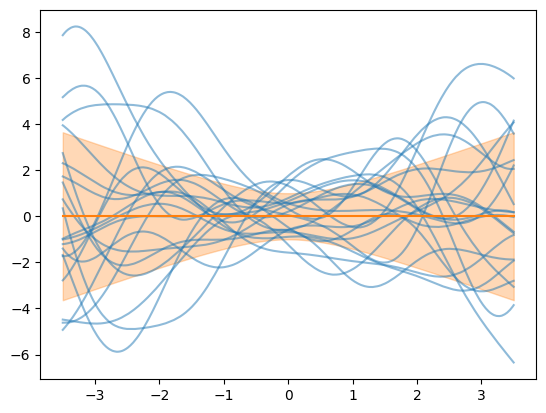

In [42]:
parameter_state = gpx.initialise(prior, key)
prior_dist = prior(parameter_state.params)(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.stddev()
samples = prior_dist.sample(seed=key, sample_shape=(20,)).T

plt.plot(xtest, samples, color="tab:blue", alpha=0.5)
plt.plot(xtest, prior_mean, color="tab:orange")
plt.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    color="tab:orange",
    alpha=0.3,
)
plt.show()

In [43]:
parameter_state

# Train

In [44]:
likelihood = gpx.Gaussian(num_datapoints=D.n) 
# likelihood = gpx.Polynomial(num_datapoints=D.n) 

In [45]:
posterior = prior * likelihood

In [47]:
# parameter_state = gpx.initialise(
#     posterior, key, kernel={"lengthscale": jnp.array([0.5])}
# )
parameter_state = gpx.initialise(
    posterior, key
)
print(type(parameter_state))

<class 'gpjax.parameters.ParameterState'>


In [48]:
params, trainable, bijectors = parameter_state.unpack()
pp.pprint(params)

{   'kernel': [   {   'lengthscale': Array([1.], dtype=float64),
                      'variance': Array([1.], dtype=float64)},
                  {   'shift': Array([1.], dtype=float64),
                      'variance': Array([1.], dtype=float64)}],
    'likelihood': {'obs_noise': Array([1.], dtype=float64)},
    'mean_function': {}}


In [38]:
params, trainable, bijectors = parameter_state.unpack()
pp.pprint(params)

{   'kernel': {   'lengthscale': Array([0.5], dtype=float64),
                  'variance': Array([1.], dtype=float64)},
    'likelihood': {'obs_noise': Array([1.], dtype=float64)},
    'mean_function': {}}


In [50]:
# marginak likelihood
negative_mll = jit(posterior.marginal_log_likelihood(D, negative=True))
negative_mll(params)

Array(125.43703322, dtype=float64)

In [51]:
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=500,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 787.36it/s, Objective=34.94]


In [52]:
learned_params, training_history = inference_state.unpack()

pp.pprint(learned_params)

{   'kernel': [   {   'lengthscale': Array([0.44963532], dtype=float64),
                      'variance': Array([0.37530829], dtype=float64)},
                  {   'shift': Array([3.18265053], dtype=float64),
                      'variance': Array([0.18410799], dtype=float64)}],
    'likelihood': {'obs_noise': Array([0.06277218], dtype=float64)},
    'mean_function': {}}


In [53]:
latent_dist = posterior(learned_params, D)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

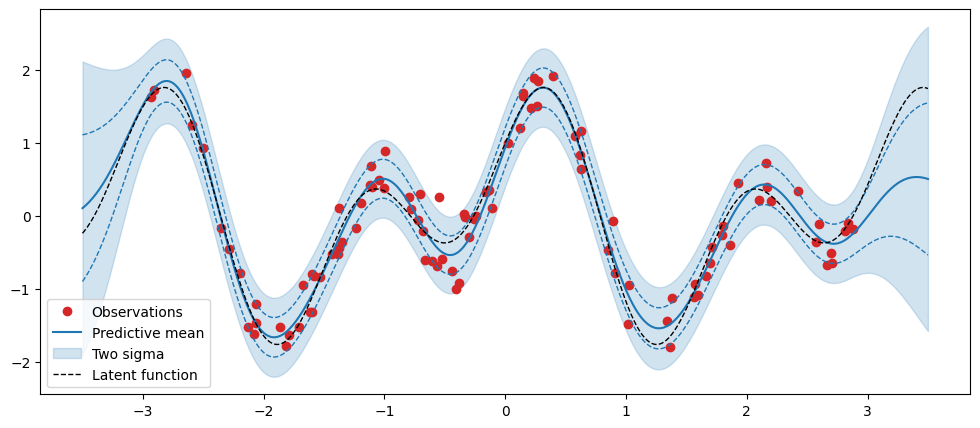

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.plot(
    xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1
)

ax.legend()

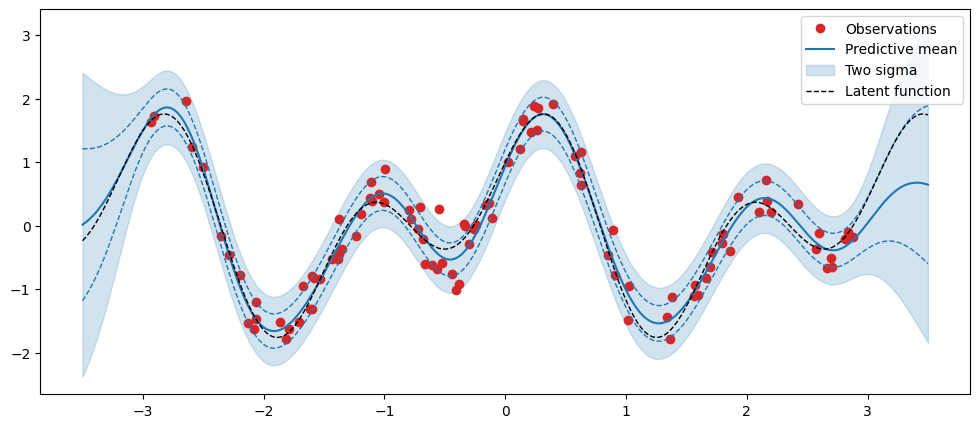

In [54]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.plot(
    xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1
)

ax.legend()

In [15]:
predictive_std

Array([1.00436167, 0.98989847, 0.97478373, 0.95902351, 0.94262733,
       0.92560831, 0.9079833 , 0.889773  , 0.87100208, 0.85169929,
       0.8318975 , 0.81163375, 0.79094932, 0.76988972, 0.74850468,
       0.72684812, 0.70497811, 0.68295679, 0.66085025, 0.6387284 ,
       0.6166648 , 0.59473643, 0.57302343, 0.5516087 , 0.53057755,
       0.51001705, 0.49001542, 0.4706611 , 0.4520417 , 0.43424268,
       0.41734575, 0.40142699, 0.38655472, 0.37278719, 0.36017009,
       0.34873424, 0.33849351, 0.32944323, 0.32155945, 0.31479908,
       0.30910111, 0.30438877, 0.30057266, 0.29755428, 0.29522998,
       0.29349474, 0.29224567, 0.29138496, 0.29082218, 0.29047602,
       0.29027526, 0.29015929, 0.29007816, 0.2899922 , 0.28987148,
       0.2896949 , 0.28944933, 0.28912851, 0.28873203, 0.28826416,
       0.28773285, 0.28714867, 0.28652384, 0.28587132, 0.28520405,
       0.28453425, 0.28387281, 0.28322893, 0.28260975, 0.28202022,
       0.28146301, 0.28093865, 0.28044566, 0.27998084, 0.27953